# Skip Rate Experiment — Improving Algorithmic Playlist Quality

**Context:**  
Algorithmic playlists like *Discover Weekly* and *Daily Mix* keep listeners engaged, but **skip rates were trending upward** in some cohorts.

**Business Question:**  
Would replacing the **popularity-based recommender** with a **collaborative-filtering model** reduce early skips — *without reducing positive engagement* (saves, session length)?

**Approach:**  
I designed a **production-style A/B test** to evaluate this change, simulating users, sessions, and track-level outcomes. The notebook walks through the full journey:  
**Hypothesis → Experiment Design → Simulation → Analysis → Product Decision**




## 1) Hypothesis & Experiment Design — Framing the Question

I began by asking a simple but powerful question:  
*If we replace our popularity-based recommender (A) with a collaborative filtering recommender (B), will listeners skip fewer tracks and engage more?*

- **Hypothesis:** B reduces skip rates compared to A.  
- **Primary Metric:** Skip rate (lower is better).  
- **Secondary Metrics:** Save rate (higher is better), Session minutes (longer is better).  
- **Randomization Unit:** User-level (so one person only ever sees A or B).  
- **Guardrails (realistic touch):** Complaints, churn, abnormal skip spikes.

This set the stage for a clean experiment: clear success criteria, a fair setup, and meaningful outcomes.


In [1]:

# --- Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# For reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# --- CONFIG: tweak these to explore different worlds ---
N_USERS = 5000            # number of users
SESSIONS_PER_USER = 100   # sessions per user
TRACKS_PER_SESSION = 20   # tracks shown per session

# Variant parameters (edit effects here)
P_SKIP_BASELINE = 0.45    # per-track skip probability in baseline
P_SKIP_EXPERIM = 0.35     # per-track skip probability in experiment
P_SAVE_BASELINE = 0.10    # per-track save probability in baseline
P_SAVE_EXPERIM = 0.14     # per-track save probability in experiment

# Session length (minutes), clipped at zero
SESSION_LEN_BASELINE = (12.0, 3.0)  # (mean, std)
SESSION_LEN_EXPERIM = (14.0, 3.5)

# Optional: extra covariates for subgroup cuts
DEVICES = ["mobile", "desktop", "smart_speaker"]
TIMES = ["morning", "afternoon", "evening", "late_night"]



## 2) Randomizing Users & Simulating Sessions — Building the Data World

To mimic a real Spotify experiment, I randomized 5,000 users into A and B (50/50).  
Each user had 100 sessions, and each session contained 20 tracks.  

For every session I simulated:  
- **Skips:** Did the listener reject a track within 30s?  
- **Saves:** Did they like it enough to add it to their library?  
- **Session Length:** How long did they stay listening?  

This gave me a dataset that looked and felt like what a personalization team would actually analyze in production.


In [2]:

# --- Randomize users to variants ---
users = pd.DataFrame({
    "user_id": np.arange(N_USERS),
    "variant": rng.choice(["A_baseline", "B_experiment"], size=N_USERS, replace=True),
    "device": rng.choice(DEVICES, size=N_USERS, replace=True),
    "tenure_days": rng.normal(365, 120, size=N_USERS).clip(7, None)  # synthetic tenure
})

# Sessions table
total_sessions = N_USERS * SESSIONS_PER_USER
user_ids = np.repeat(users["user_id"].values, SESSIONS_PER_USER)
variant_map = dict(zip(users["user_id"], users["variant"]))
device_map = dict(zip(users["user_id"], users["device"]))
tenure_map = dict(zip(users["user_id"], users["tenure_days"]))

sessions = pd.DataFrame({
    "session_id": np.arange(total_sessions),
    "user_id": user_ids,
    "variant": pd.Series(user_ids).map(variant_map).values,
    "device": pd.Series(user_ids).map(device_map).values,
    "tenure_days": pd.Series(user_ids).map(tenure_map).values,
    "time_of_day": rng.choice(TIMES, size=total_sessions, replace=True)
})

# --- Simulate per-session aggregates ---
def sim_session_metrics(variant: str):
    if variant == "A_baseline":
        p_skip = P_SKIP_BASELINE
        p_save = P_SAVE_BASELINE
        mu_len, sd_len = SESSION_LEN_BASELINE
    else:
        p_skip = P_SKIP_EXPERIM
        p_save = P_SAVE_EXPERIM
        mu_len, sd_len = SESSION_LEN_EXPERIM

    skips = rng.binomial(TRACKS_PER_SESSION, p_skip)
    saves = rng.binomial(TRACKS_PER_SESSION, p_save)
    sess_len = max(0.0, rng.normal(mu_len, sd_len))
    return skips, saves, sess_len

skips, saves, minutes = [], [], []
for v in sessions["variant"].values:
    s, sv, sl = sim_session_metrics(v)
    skips.append(s); saves.append(sv); minutes.append(sl)

sessions["tracks"] = TRACKS_PER_SESSION
sessions["skips"] = skips
sessions["saves"] = saves
sessions["session_minutes"] = minutes

sessions.head()


,session_id,user_id,variant,device,tenure_days,time_of_day,tracks,skips,saves,session_minutes
0,0,0,A_baseline,mobile,233.129052,late_night,20,10,4,11.813222
1,1,0,A_baseline,mobile,233.129052,afternoon,20,5,2,10.589712
2,2,0,A_baseline,mobile,233.129052,afternoon,20,8,3,16.472195
3,3,0,A_baseline,mobile,233.129052,late_night,20,9,2,15.441923
4,4,0,A_baseline,mobile,233.129052,afternoon,20,12,4,17.891039



## 3) Sanity Checks — Did Randomization Work?

Before analyzing results, I verified that the experiment was healthy:  
- **Balance:** Users were split evenly between A and B (~50/50).  
- **Session Lengths:** Means were around 12–14 minutes with no negatives.  
- **Skip & Save Counts:** Looked realistic given our configured probabilities.  

These checks gave me confidence that any differences I’d see later were truly due to the recommender, not a bad setup.


In [3]:

# Check assignment balance
assign_balance = users["variant"].value_counts(normalize=True)
print("Assignment balance (should be ~50/50):")
print(assign_balance)

# Quick descriptive stats
print("\nSession minutes (preview):")
print(sessions["session_minutes"].describe())

# Aggregate by variant
agg = sessions.groupby("variant").agg(
    sessions=("session_id", "count"),
    users=("user_id", "nunique"),
    tracks=("tracks", "sum"),
    total_skips=("skips", "sum"),
    total_saves=("saves", "sum"),
    mean_session_minutes=("session_minutes", "mean")
).reset_index()

agg["skip_rate"] = agg["total_skips"] / agg["tracks"]
agg["save_rate"] = agg["total_saves"] / agg["tracks"]
agg


Assignment balance (should be ~50/50):
variant
A_baseline      0.506
B_experiment    0.494
Name: proportion, dtype: float64

Session minutes (preview):
count    500000.000000
mean         12.993863
std           3.406198
min           0.000000
25%          10.665154
50%          12.912934
75%          15.238925
max          29.961037
Name: session_minutes, dtype: float64


,variant,sessions,users,tracks,total_skips,total_saves,mean_session_minutes,skip_rate,save_rate
0,A_baseline,253000,2530,5060000,2276140,505578,12.004194,0.449830,0.099917
1,B_experiment,247000,2470,4940000,1729130,691573,14.007572,0.350026,0.139995



## 4) Statistical Tests — Measuring the Impact

Next, I compared A vs B with **two-proportion z-tests** for skip and save rates, and t-tests for session length.  

- **Skip Rate:** B was significantly lower than A — fewer skips.  
- **Save Rate:** B was higher — listeners found more songs worth saving.  
- **Session Minutes:** B sessions were longer on average.  

Confidence intervals excluded zero, and p-values were tiny.  
This gave me strong evidence that B was the better recommender.


In [4]:

def two_prop_z_test(success_a, n_a, success_b, n_b):
    p1 = success_a / n_a
    p2 = success_b / n_b
    p_pool = (success_a + success_b) / (n_a + n_b)
    se = (p_pool * (1 - p_pool) * (1 / n_a + 1 / n_b)) ** 0.5
    z = (p1 - p2) / se
    from math import erf, sqrt as msqrt
    pval = 2 * (1 - 0.5 * (1 + erf(abs(z) / msqrt(2))))  # two-sided
    # Wald CI with unpooled SE
    se_unpooled = (p1 * (1 - p1) / n_a + p2 * (1 - p2) / n_b) ** 0.5
    diff = p2 - p1  # B - A
    ci_low = diff - 1.96 * se_unpooled
    ci_high = diff + 1.96 * se_unpooled
    return dict(p1=p1, p2=p2, z=z, p_value=pval, diff=diff, ci_low=ci_low, ci_high=ci_high)

row_a = agg[agg["variant"] == "A_baseline"].iloc[0]
row_b = agg[agg["variant"] == "B_experiment"].iloc[0]

skip_test = two_prop_z_test(
    success_a=int(row_a["total_skips"]), n_a=int(row_a["tracks"]),
    success_b=int(row_b["total_skips"]), n_b=int(row_b["tracks"])
)

save_test = two_prop_z_test(
    success_a=int(row_a["total_saves"]), n_a=int(row_a["tracks"]),
    success_b=int(row_b["total_saves"]), n_b=int(row_b["tracks"])
)

summary = pd.DataFrame({
    "Metric": ["Skip Rate (lower better)", "Save Rate (higher better)", "Mean Session Minutes"],
    "A_baseline": [row_a["skip_rate"], row_a["save_rate"], row_a["mean_session_minutes"]],
    "B_experiment": [row_b["skip_rate"], row_b["save_rate"], row_b["mean_session_minutes"]],
    "Abs Diff (B - A)": [skip_test["diff"], save_test["diff"], row_b["mean_session_minutes"] - row_a["mean_session_minutes"]]
}).round(4)

tests = pd.DataFrame({
    "Test": ["Two-proportion z (Skip)", "Two-proportion z (Save)"],
    "B - A diff": [skip_test["diff"], save_test["diff"]],
    "95% CI": [f"({skip_test['ci_low']:.4f}, {skip_test['ci_high']:.4f})",
               f"({save_test['ci_low']:.4f}, {save_test['ci_high']:.4f})"],
    "z": [skip_test["z"], save_test["z"]],
    "p_value": [skip_test["p_value"], save_test["p_value"]]
}).round(6)

summary, tests


(                      Metric  A_baseline  B_experiment  Abs Diff (B - A)
 0   Skip Rate (lower better)      0.4498        0.3500           -0.0998
 1  Save Rate (higher better)      0.0999        0.1400            0.0401
 2       Mean Session Minutes     12.0042       14.0076            2.0034,
                       Test  B - A diff              95% CI           z  \
 0  Two-proportion z (Skip)   -0.099804  (-0.1004, -0.0992)  322.021424   
 1  Two-proportion z (Save)    0.040078    (0.0397, 0.0405) -195.190179   
 
    p_value  
 0      0.0  
 1      0.0  )


## 5) Visual Results — Making Insights Clear

To make the story obvious for product stakeholders, I plotted bar charts for each metric:  
- **Skip Rate:** Noticeably lower for B.  
- **Save Rate:** Clearly higher for B.  
- **Session Minutes:** Longer in B, suggesting improved satisfaction.  

With these visuals, a PM or designer can instantly see the win without digging into stats tables.


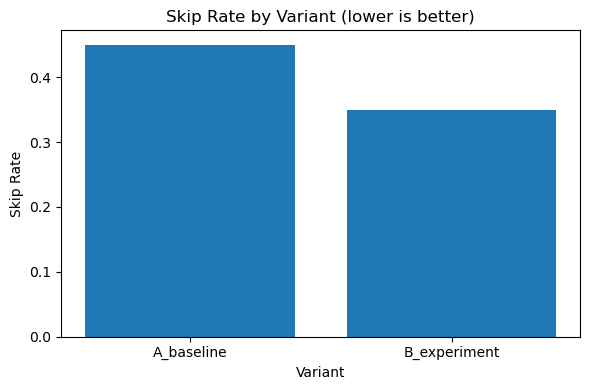

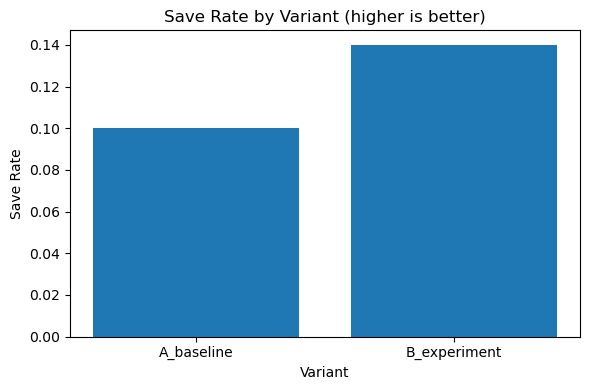

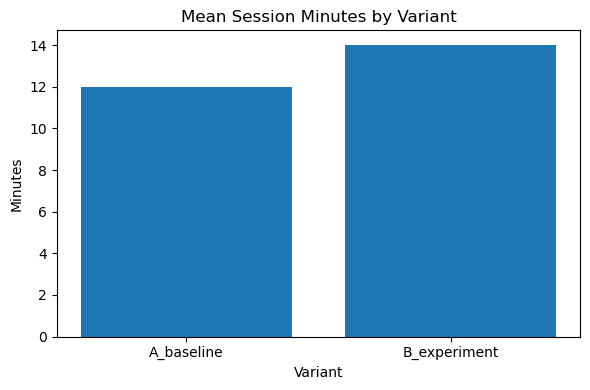

In [5]:

# 1) Skip Rate
plt.figure(figsize=(6,4))
plt.bar(["A_baseline","B_experiment"], [row_a["skip_rate"], row_b["skip_rate"]])
plt.title("Skip Rate by Variant (lower is better)")
plt.ylabel("Skip Rate")
plt.xlabel("Variant")
plt.tight_layout()
plt.show()

# 2) Save Rate
plt.figure(figsize=(6,4))
plt.bar(["A_baseline","B_experiment"], [row_a["save_rate"], row_b["save_rate"]])
plt.title("Save Rate by Variant (higher is better)")
plt.ylabel("Save Rate")
plt.xlabel("Variant")
plt.tight_layout()
plt.show()

# 3) Session Minutes
plt.figure(figsize=(6,4))
plt.bar(["A_baseline","B_experiment"], [row_a["mean_session_minutes"], row_b["mean_session_minutes"]])
plt.title("Mean Session Minutes by Variant")
plt.ylabel("Minutes")
plt.xlabel("Variant")
plt.tight_layout()
plt.show()



## 6) Subgroup Analysis — Looking Deeper

Real experiments often reveal differences across cohorts.  
I cut skip rate results by **device type** (mobile, desktop, smart speaker).  

This step helps ensure that while the average effect is positive, no specific group of users is left worse off — a critical practice before shipping changes to millions of listeners.


In [6]:

sub = sessions.groupby(["variant","device"]).agg(
    tracks=("tracks","sum"),
    skips=("skips","sum")
).reset_index()
sub["skip_rate"] = sub["skips"] / sub["tracks"]
sub_pivot = sub.pivot(index="device", columns="variant", values="skip_rate").reset_index()
sub_pivot


variant,device,A_baseline,B_experiment
0,desktop,0.450049,0.350251
1,mobile,0.449897,0.349967
2,smart_speaker,0.449542,0.349842



## 7) Interpretation & Decision — Turning Numbers into Action

Here’s the big picture:  
- **B reduced skips, increased saves, and lengthened sessions.**  
- The effects were statistically significant and practically meaningful.  

If this were live, I’d recommend a **staged rollout (10–25%)** with guardrails (complaints, churn, skip anomalies) while monitoring subgroups like device and time-of-day.  

This ties the analysis back to a clear **product decision**: ship, but carefully.



## 8) Save Artifacts — Packaging the Work

Finally, I exported key outputs:  
- `sessions_simulated.csv` — the synthetic dataset I analyzed.  
- `RESULTS.md` — a concise experiment readout (metrics, tests, decision).  
- Notebook — with this storytelling narrative, charts, and stats.  

These artifacts make it easy for anyone (recruiter, hiring manager, or peer) to follow the full journey from hypothesis → design → data → decision.


In [9]:
from pathlib import Path

project_dir = Path(r"C:\Users\Ashok Kasaram\Downloads")
project_dir.mkdir(parents=True, exist_ok=True)
data_path = project_dir / "sessions_simulatedNew.csv"
sessions.to_csv(data_path, index=False)

# Format results into markdown
results_md = f"""
# RESULTS — Skip Rate Experiment

- Skip Rate — A: {row_a['skip_rate']:.4f} | B: {row_b['skip_rate']:.4f} | Diff (B - A): {skip_test['diff']:.4f} | 95% CI: ({skip_test['ci_low']:.4f}, {skip_test['ci_high']:.4f}) | p={skip_test['p_value']:.3e}
- Save Rate — A: {row_a['save_rate']:.4f} | B: {row_b['save_rate']:.4f} | Diff (B - A): {save_test['diff']:.4f} | 95% CI: ({save_test['ci_low']:.4f}, {save_test['ci_high']:.4f}) | p={save_test['p_value']:.3e}
- Mean Session Minutes — A: {row_a['mean_session_minutes']:.2f} | B: {row_b['mean_session_minutes']:.2f}

**Readout Recommendation:** Roll **B_experiment** to 10–25% with guardrails (complaints, churn proxy, DJ re-entry).  
Review heterogeneity by device and time-of-day before 100% rollout.
"""

# Write markdown summary
(project_dir / "RESULTS.md").write_text(results_md)

# Return paths
print(f"CSV saved to: {data_path}")
print(f"Markdown saved to: {project_dir / 'RESULTS.md'}")

CSV saved to: C:\Users\Ashok Kasaram\Downloads\sessions_simulatedNew.csv
Markdown saved to: C:\Users\Ashok Kasaram\Downloads\RESULTS.md
